<a href="https://colab.research.google.com/github/bringol/AbacuyML_Autogenerador/blob/main/Abacuy_Generador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1 Descomprimir el Dataset

In [1]:
import zipfile
import os

zip_file_path = "/content/drive/MyDrive/Facultad/UADE/PFI/PFI 2025/dataset/dataset-soroban.zip"
destination_dir = "/content/dataset-soroban"

# Crea el directorio destino si no existe
os.makedirs(destination_dir, exist_ok=True)

# Extrae todo el contenido del ZIP
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_dir)

print(f"Dataset descomprimido en: {destination_dir}")

Dataset descomprimido en: /content/dataset-soroban


Verificar el contenido

In [45]:
base_dir = "/content/dataset-soroban/dataset-soroban" # Updated path

# Mostrar carpetas dentro del dataset
print("📁 Carpetas encontradas:")
for nombre in sorted(os.listdir(base_dir)):
    ruta = os.path.join(base_dir, nombre)
    # if os.path.isdir(ruta): # commented out to show all items
    print(" -", nombre)

Streaming output truncated to the last 5000 lines.
 - 12-kyu-H83sBp.html
 - 12-kyu-H9BMwc.html
 - 12-kyu-H9YgYX.html
 - 12-kyu-HA9E4j.html
 - 12-kyu-HBDAug.html
 - 12-kyu-HCGxdj.html
 - 12-kyu-HCVvnp.html
 - 12-kyu-HCZANU.html
 - 12-kyu-HCvX6L.html
 - 12-kyu-HDaqSf.html
 - 12-kyu-HDv2v7.html
 - 12-kyu-HE8JT7.html
 - 12-kyu-HEBSQb.html
 - 12-kyu-HEXQfu.html
 - 12-kyu-HEZhmm.html
 - 12-kyu-HHYLDZ.html
 - 12-kyu-HHaann.html
 - 12-kyu-HJ7V8D.html
 - 12-kyu-HL2fPa.html
 - 12-kyu-HL4mQ7.html
 - 12-kyu-HMGMsY.html
 - 12-kyu-HN63Gs.html
 - 12-kyu-HNK9Bc.html
 - 12-kyu-HNcS7g.html
 - 12-kyu-HP95XF.html
 - 12-kyu-HPR8rh.html
 - 12-kyu-HR98UT.html
 - 12-kyu-HRDwnH.html
 - 12-kyu-HRWQT2.html
 - 12-kyu-HSQeqW.html
 - 12-kyu-HSc45M.html
 - 12-kyu-HT4qDF.html
 - 12-kyu-HTLmPk.html
 - 12-kyu-HTT2zU.html
 - 12-kyu-HTkGWM.html
 - 12-kyu-HU8uGp.html
 - 12-kyu-HUAUJu.html
 - 12-kyu-HUejDF.html
 - 12-kyu-HUvBjr.html
 - 12-kyu-HUxKGq.html
 - 12-kyu-HUy6YF.html
 - 12-kyu-HWLXx5.html
 - 12-kyu-HXeSC2.html
 - 

# 2 Procesar todo el dataset y exportar a CSV

Toma Alrededor de 10 min

In [56]:
from bs4 import BeautifulSoup
import pandas as pd
import glob
import os
import re

def procesar_html_soroban(path_html, kyu):
    with open(path_html, "r", encoding="utf-8") as f:
        soup = BeautifulSoup(f, "html.parser")

    table = soup.find("table")
    if not table:
        return []

    rows = table.find_all("tr")
    header_cells = rows[0].find_all(["td", "th"])
    difficulties = [cell.get_text().count("★") for cell in header_cells]
    num_ejercicios = len(difficulties)
    ejercicios = []

    for col_idx in range(num_ejercicios):
        expression = []
        negative_present = False
        length = 0

        for row in rows[1:-2]:
            cells = row.find_all(["td", "th"])
            if col_idx < len(cells):
                raw = cells[col_idx].get_text(strip=True)
                if raw:
                    if raw.startswith("-"):
                        negative_present = True
                    expression.append(raw)
                    length += 1

        if length == 0:
            continue

        # Tokens con metadatos
        op_token = "<add_sub>"
        kyu_token = f"<kyu:{kyu}>"
        diff = difficulties[col_idx]
        diff_token = f"<diff:{diff}>"
        type_token = "<add_and_sub>" if negative_present else "<only_add>"
        length_token = f"<length:{length}>"

        # Cuenta formateada como texto: "5 + 9 + 4"
        formatted_expr = " + ".join(expression)

        # Secuencia completa (como antes)
        full_sequence = f"{op_token} {kyu_token} {diff_token} {type_token} {length_token} {formatted_expr}"

        # Agregamos como diccionario para armar columnas fácilmente
        ejercicios.append({
            "seq": full_sequence,
            "exp": formatted_expr,
            "len": length,
            "kyu": kyu,
            "diff": diff,
            "type": "add_and_sub" if negative_present else "only_add"
        })

    return ejercicios

# 🔁 Procesar todos los archivos desde una sola carpeta
base_dir = "/content/dataset-soroban/dataset-soroban"
html_files = glob.glob(f"{base_dir}/*.html")
todos_ejercicios = []

print(f"🔎 Archivos HTML encontrados: {len(html_files)}")

for path_html in html_files:
    filename = os.path.basename(path_html)
    match = re.match(r"(\d+)-kyu", filename)
    if not match:
        print(f"⚠️ Archivo con nombre inesperado: {filename}")
        continue

    kyu = int(match.group(1))
    ejercicios = procesar_html_soroban(path_html, kyu)
    todos_ejercicios.extend(ejercicios)

print(f"\n✅ Total de secuencias generadas: {len(todos_ejercicios)}")

# 💾 Guardar a CSV
df = pd.DataFrame(todos_ejercicios)
df.to_csv("entrenamiento_soroban.csv", index=False)
print("✅ CSV guardado como entrenamiento_soroban.csv")


🔎 Archivos HTML encontrados: 35400

✅ Total de secuencias generadas: 354000
✅ CSV guardado como entrenamiento_soroban.csv


Verifico el resultado

In [57]:
import pandas as pd

df = pd.read_csv("entrenamiento_soroban.csv")
print("✅ Total de secuencias en el CSV:", len(df))
df.sample(5, random_state=42)  # Mostrar 5 ejemplos aleatorios


✅ Total de secuencias en el CSV: 354000


,seq,exp,len,kyu,diff,type
81484,<add_sub> <kyu:6> <diff:2> <add_and_sub> <leng...,56 + 959 + 81 + 76 + 44 + -207 + 975 + 61 + 28...,15,6,2,add_and_sub
124528,<add_sub> <kyu:12> <diff:1> <only_add> <length...,4 + 1 + 4 + 7 + 2,5,12,1,only_add
212993,<add_sub> <kyu:6> <diff:2> <only_add> <length:...,611 + 485 + 483 + 181 + 774 + 328 + 685 + 732 ...,10,6,2,only_add
62314,<add_sub> <kyu:12> <diff:3> <only_add> <length...,2 + 3 + 6 + 8 + 3,5,12,3,only_add
128044,<add_sub> <kyu:5> <diff:2> <add_and_sub> <leng...,6214 + -2738 + 6039 + -2297 + 5456 + -1268 + 1...,10,5,2,add_and_sub


# 3. Análisis Exploratorio

## Gáficos

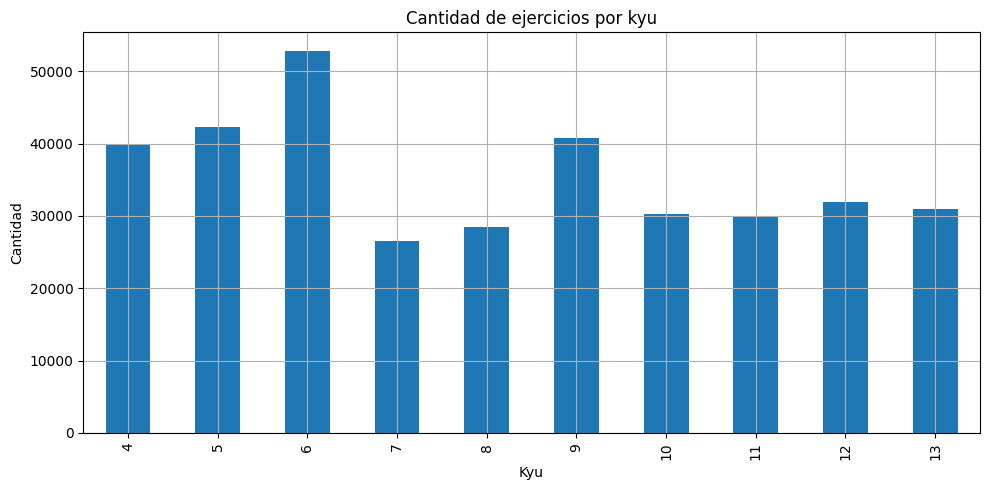

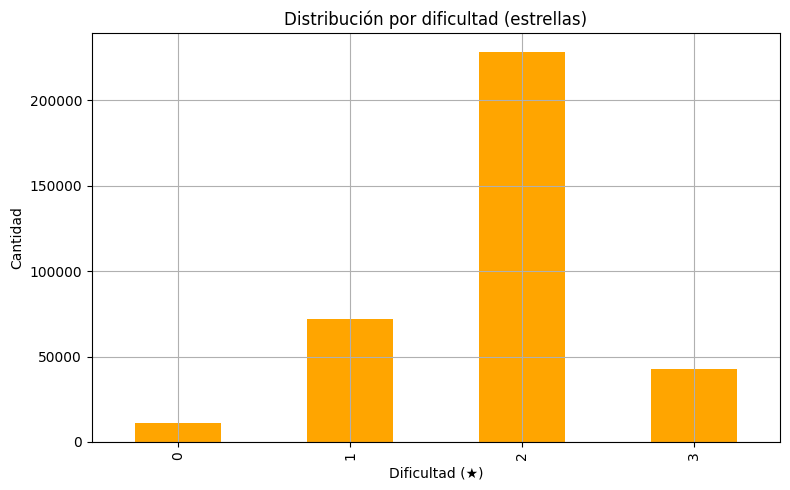

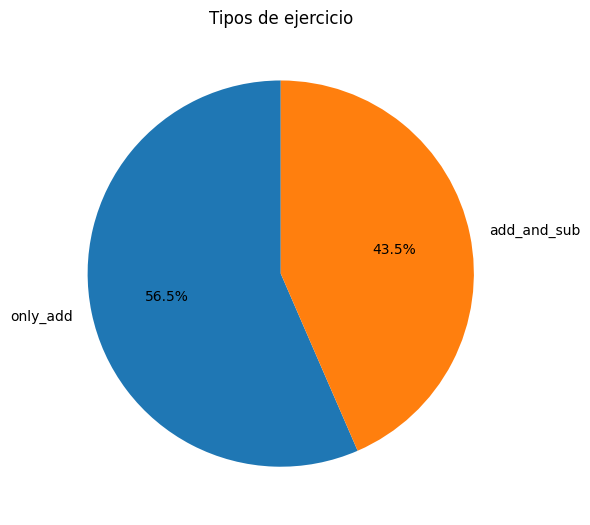

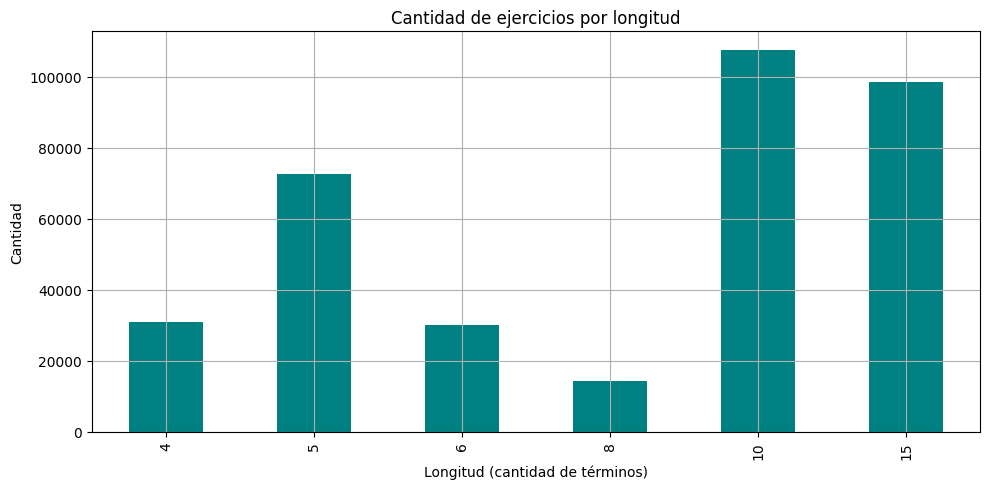

📈 Estadísticas de longitud:
- Mínima:  4
- Máxima:  15
- Promedio: 9.42


In [66]:
import matplotlib.pyplot as plt

# 📊 1. Distribución de ejercicios por Kyu
plt.figure(figsize=(10, 5))
df["kyu"].value_counts().sort_index().plot(kind="bar")
plt.title("Cantidad de ejercicios por kyu")
plt.xlabel("Kyu")
plt.ylabel("Cantidad")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📊 2. Distribución por dificultad
plt.figure(figsize=(8, 5))
df["diff"].value_counts().sort_index().plot(kind="bar", color="orange")
plt.title("Distribución por dificultad (estrellas)")
plt.xlabel("Dificultad (★)")
plt.ylabel("Cantidad")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📊 3. Distribución por tipo de ejercicio
plt.figure(figsize=(6, 6))
df["type"].value_counts().plot(kind="pie", autopct='%1.1f%%', startangle=90)
plt.title("Tipos de ejercicio")
plt.ylabel("")  # Saca la etiqueta del eje Y
plt.tight_layout()
plt.show()


# 📊 4. Conteo exacto por longitud
plt.figure(figsize=(10, 5))
df["len"].value_counts().sort_index().plot(kind="bar", color="teal")
plt.title("Cantidad de ejercicios por longitud")
plt.xlabel("Longitud (cantidad de términos)")
plt.ylabel("Cantidad")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📈 5. Estadísticas básicas de longitud
print("📈 Estadísticas de longitud:")
print(f"- Mínima:  {df['len'].min()}")
print(f"- Máxima:  {df['len'].max()}")
print(f"- Promedio: {df['len'].mean():.2f}")

## Ejercicios sin dificultad

###Existen casos donde los ejercicios no poseen una dificultad asociada (diff). Por lo que hay que analizar cuántos son exactamente en comparación con el total

la parte de abajo rompe el csv original???

In [63]:
# Filtrar casos sin dificultad detectada correctamente
problemas = df[df["diff"].isna() | (df["diff"] == 0)]
print("⚠️ Ejercicios sin dificultad válida:", len(problemas))

# Mostrar algunos ejemplos
problemas["seq"].sample(5, random_state=42)
print(problemas["seq"].sample(5, random_state=42))


# Total de secuencias en el dataset
total = len(df)

# Total de secuencias con dificultad inválida
invalidas = len(df[df["diff"].isna() | (df["diff"] == 0)])

# Calcular porcentaje
porcentaje = (invalidas / total) * 100


print(f"🔢 Total de secuencias: {total}")
print(f"📊 Porcentaje afectado: {porcentaje:.2f}%")




⚠️ Ejercicios sin dificultad válida: 11248
181378    <add_sub> <kyu:6> <diff:0> <add_and_sub> <leng...
229795    <add_sub> <kyu:10> <diff:0> <add_and_sub> <len...
187781    <add_sub> <kyu:6> <diff:0> <only_add> <length:...
120782    <add_sub> <kyu:9> <diff:0> <add_and_sub> <leng...
201369    <add_sub> <kyu:10> <diff:0> <add_and_sub> <len...
Name: seq, dtype: object
🔢 Total de secuencias: 354000
📊 Porcentaje afectado: 3.18%


## Eliminación de Ejercicios Sin Dificultad
Al tratarse de un bajo porcentaje, se omitirán las secuencias con dificultad inválida.

In [65]:
import pandas as pd

# 📥 Leer el CSV original
df = pd.read_csv("entrenamiento_soroban.csv")

# 🧹 Filtrar ejercicios con dificultad válida (diff distinto de 0 y no nulo)
df_filtrado = df[df["diff"].notna() & (df["diff"] != 0)]

# 💾 Guardar el nuevo CSV filtrado
df_filtrado.to_csv("entrenamiento_soroban_filtrado.csv", index=False)

# ✅ Confirmación
print("✅ Dataset limpio guardado como 'entrenamiento_soroban_filtrado.csv'")
print(f"🔢 Total de filas originales: {len(df)}")
print(f"🔻 Total de filas después del filtrado: {len(df_filtrado)}")
print(f"❌ Filas eliminadas: {len(df) - len(df_filtrado)}")


✅ Dataset limpio guardado como 'entrenamiento_soroban_filtrado.csv'
🔢 Total de filas originales: 354000
🔻 Total de filas después del filtrado: 342752
❌ Filas eliminadas: 11248


## Gráfico con Datos Filtrados

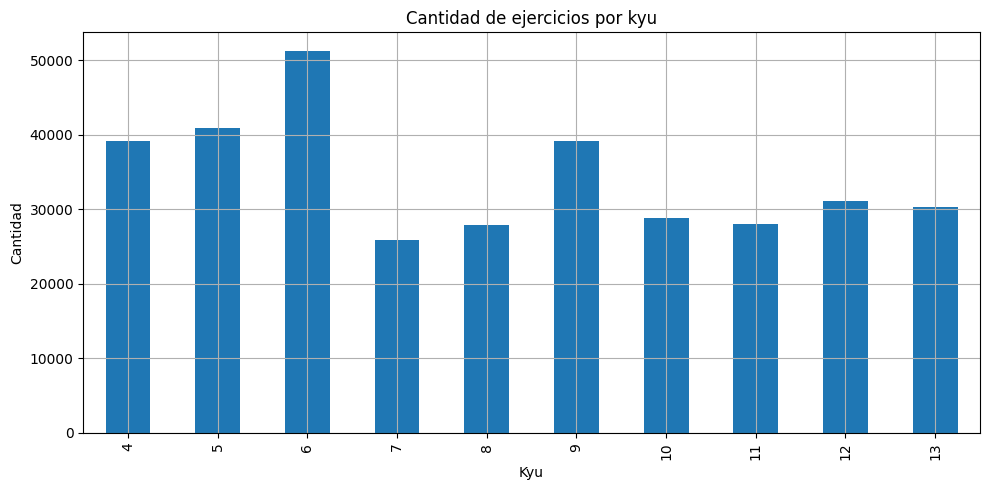

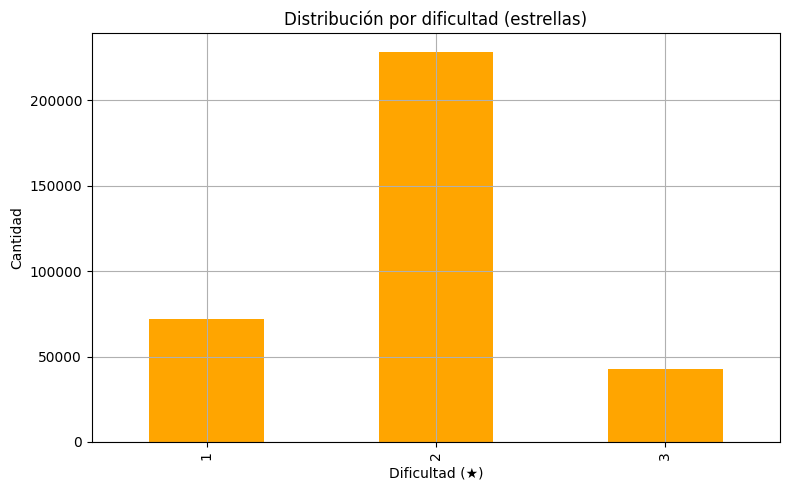

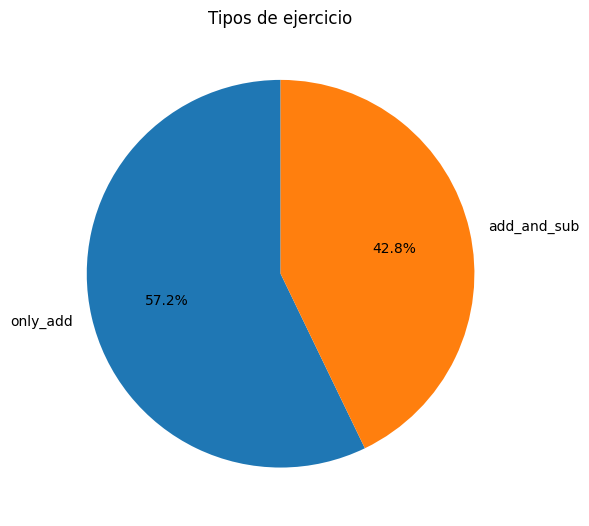

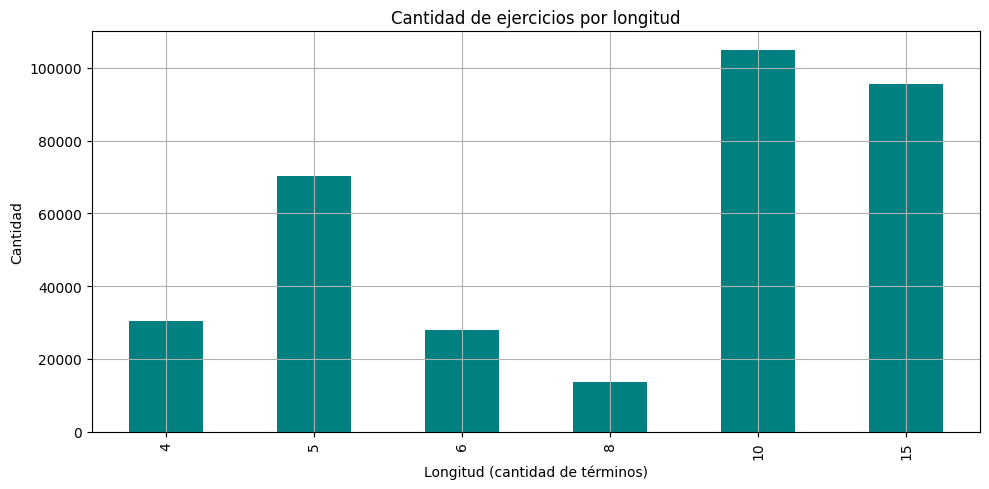

📈 Estadísticas de longitud:
- Mínima:  4
- Máxima:  15
- Promedio: 9.43


In [67]:
import pandas as pd
import matplotlib.pyplot as plt

# 📥 Leer el dataset filtrado
df_filtrado = pd.read_csv("entrenamiento_soroban_filtrado.csv")

# 📊 1. Distribución de ejercicios por Kyu
plt.figure(figsize=(10, 5))
df_filtrado["kyu"].value_counts().sort_index().plot(kind="bar")
plt.title("Cantidad de ejercicios por kyu")
plt.xlabel("Kyu")
plt.ylabel("Cantidad")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📊 2. Distribución por dificultad
plt.figure(figsize=(8, 5))
df_filtrado["diff"].value_counts().sort_index().plot(kind="bar", color="orange")
plt.title("Distribución por dificultad (estrellas)")
plt.xlabel("Dificultad (★)")
plt.ylabel("Cantidad")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📊 3. Distribución por tipo de ejercicio
plt.figure(figsize=(6, 6))
df_filtrado["type"].value_counts().plot(kind="pie", autopct='%1.1f%%', startangle=90)
plt.title("Tipos de ejercicio")
plt.ylabel("")  # Saca la etiqueta del eje Y
plt.tight_layout()
plt.show()

# 📊 4. Distribución por longitud de expresión
plt.figure(figsize=(10, 5))
df_filtrado["len"].value_counts().sort_index().plot(kind="bar", color="teal")
plt.title("Cantidad de ejercicios por longitud")
plt.xlabel("Longitud (cantidad de términos)")
plt.ylabel("Cantidad")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📈 5. Estadísticas básicas de longitud
print("📈 Estadísticas de longitud:")
print(f"- Mínima:  {df_filtrado['len'].min()}")
print(f"- Máxima:  {df_filtrado['len'].max()}")
print(f"- Promedio: {df_filtrado['len'].mean():.2f}")


revisaaar lo de abajoooo

#4 Preparación

## a) Cargar el CSV limpio y dividirlo

In [12]:
# ✅ Librerías necesarias
import pandas as pd
from sklearn.model_selection import train_test_split

# 📂 Cargar el CSV filtrado previamente
df = pd.read_csv("entrenamiento_soroban_filtrado.csv")

# 📌 División: 70% entrenamiento, 30% temporal (para val y test)
# ✔️ Usamos 'stratify' para conservar las proporciones de dificultad 1, 2 y 3
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,               # 30% queda para validación + test
    stratify=df["dificultad"],   # Mantener proporción de clases
    random_state=42              # Semilla para reproducibilidad
)

# 📌 Ahora dividimos el 30% restante en 20% validación y 10% test
# Esto se hace tomando el 2/3 y 1/3 del 30%
val_df, test_df = train_test_split(
    temp_df,
    test_size=1/3,               # De 30%, 1/3 será test (≈10% del total)
    stratify=temp_df["dificultad"],
    random_state=42
)

# ✅ Mostrar tamaños finales
print(f"📊 Ejemplos de entrenamiento: {len(train_df)}")
print(f"🧪 Ejemplos de validación:    {len(val_df)}")
print(f"📘 Ejemplos de test:          {len(test_df)}")

# 💾 Guardar en archivos CSV separados (sin índice extra)
train_df.to_csv("soroban_train.csv", index=False)
val_df.to_csv("soroban_val.csv", index=False)
test_df.to_csv("soroban_test.csv", index=False)

print("✅ Archivos CSV guardados: soroban_train.csv, soroban_val.csv, soroban_test.csv")


📊 Ejemplos de entrenamiento: 239926
🧪 Ejemplos de validación:    68550
📘 Ejemplos de test:          34276
✅ Archivos CSV guardados: soroban_train.csv, soroban_val.csv, soroban_test.csv


## b) Preprocesamiento

### Tiene como objetivo preparar las secuencias de texto (ejercicios) para entrenar un modelo en TensorFlow/Keras, y que luego puedas exportar a ONNX para usar en Unity + Barracuda.

In [13]:
# ✅ Librerías necesarias
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# ✅ Cargar el CSV de entrenamiento
df = pd.read_csv("soroban_train.csv")

# ✅ Extraer la columna de texto (secuencia)
secuencias = df["Secuencia"].astype(str).tolist()

# ✅ Tokenizador de Keras (palabra por palabra, no carácter)
tokenizer = Tokenizer(
    filters="",             # No eliminamos signos como + o -
    lower=False,            # Mantenemos mayúsculas/minúsculas
    oov_token="<OOV>"       # Token especial para palabras desconocidas
)

# ✅ Ajustar el tokenizador al texto de entrenamiento
tokenizer.fit_on_texts(secuencias)

# 🔢 Convertir a secuencias numéricas
secuencias_tokenizadas = tokenizer.texts_to_sequences(secuencias)

# 🧱 Padding (relleno) para igualar la longitud de todos los ejercicios
# Asumimos "post" para rellenar al final
secuencias_padded = pad_sequences(secuencias_tokenizadas, padding='post')

# ✅ Guardamos el tokenizer para usar después en validación / test / inferencia
with open("tokenizer_soroban.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# ✅ Guardamos las secuencias ya tokenizadas
import numpy as np
np.save("soroban_train_padded.npy", secuencias_padded)

# ✅ Info útil
print(f"📏 Longitud máxima de secuencia: {secuencias_padded.shape[1]}")
print(f"🔠 Tamaño del vocabulario: {len(tokenizer.word_index)}")


📏 Longitud máxima de secuencia: 34
🔠 Tamaño del vocabulario: 117115


✅ 1. Longitud máxima de secuencia: 34

Esto significa que el ejercicio más largo dentro del conjunto de entrenamiento tiene 34 tokens (palabras).
Ejemplo de tokens en un ejercicio:

<add_sub> <kyu:11> <diff:3> <only_add> <length:6> 7 + 9 + 8 + 2 + 4 + 3


Cada elemento (<tag> o número) es considerado una palabra individual. Si un ejercicio tiene menos de 34 tokens, se rellena con ceros (padding='post') hasta alcanzar esa longitud.

🟢 ¿Por qué es útil saber esto?

Vas a definir la entrada del modelo como input_shape=(34,).

También podés ajustar este número si querés limitarlo para ahorrar memoria (por ejemplo: truncar a 30 si querés achicar el modelo).

✅ 2. Tamaño del vocabulario: 117115

Este número representa la cantidad total de tokens únicos (palabras o símbolos) encontrados en TODO tu dataset de entrenamiento.

Esto incluye:

Etiquetas (<add_sub>, <kyu:11>, <diff:2>, etc.)

Números individuales (3, 9, -7, etc.)

Operadores (+, -)

Y cualquier variante mal escrita o extraña (por eso el número puede ser alto)

🔴 Este valor es bastante elevado, lo que podría:

Volver el modelo muy pesado (mayor matriz de embeddings)

Aumentar el uso de RAM/VRAM

Incluir tokens irrelevantes o con errores (por ejemplo, espacios dobles, signos mezclados, errores tipográficos)

✅ ¿Qué podés hacer ahora?

Opción 1 (rápida):

Usar directamente los 117k tokens y avanzar al modelo.

Ideal si vas a experimentar en Colab y exportar a ONNX más adelante.

Opción 2 (recomendada):

Limitar el vocabulario al top N tokens más frecuentes, por ejemplo:

## Se opta por limitar los token a 10 mil para que el modelo no supere los 20MB

In [14]:
import numpy as np
from collections import Counter

# Distribución de frecuencia
all_counts = tokenizer.word_counts
sorted_counts = sorted(all_counts.items(), key=lambda x: x[1], reverse=True)

# Calcular tokens acumulados
total = sum(count for _, count in sorted_counts)
acumulado = 0
for i, (word, count) in enumerate(sorted_counts):
    acumulado += count
    if acumulado / total >= 0.95:
        print(f"Se necesitan {i+1} tokens para cubrir el 95% de las apariciones")
        break


Se necesitan 8981 tokens para cubrir el 95% de las apariciones


# 4) Definición del Modelo

## a) Cargar y Preparar los Datos

In [15]:
import pandas as pd
import numpy as np
import pickle
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# ⚙️ Parámetros
MAX_TOKENS = 10000
MAX_LEN = 34

# 📥 Cargar tokenizer original
with open("tokenizer_soroban.pkl", "rb") as f:
    tokenizer = pickle.load(f)

# 🧽 Limitar a los 10k tokens más frecuentes
tokenizer.num_words = MAX_TOKENS

# 📥 Cargar las secuencias tokenizadas y padded
X = np.load("soroban_train_padded.npy")

# 📥 Cargar etiquetas
df = pd.read_csv("soroban_train.csv")
y = df["dificultad"].values - 1  # Restamos 1 para que queden como [0,1,2]
y = to_categorical(y, num_classes=3)

# 🧪 División interna (puede usarse validation_split también)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

print("✔️ Datos cargados y preparados")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)


✔️ Datos cargados y preparados
X_train: (203937, 34)
y_train: (203937, 3)


## b)Definición del Modelo Base de Clasificación



In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# ⚙️ Parámetros
EMBEDDING_DIM = 64  # Dimensión del embedding
MAX_TOKENS = 10000  # Limitar a 10k tokens más frecuentes
MAX_LEN = 34        # Longitud máxima de las secuencias (tras padding)

# 🧠 Modelo secuencial
model = Sequential([
    # Embedding para convertir tokens en vectores densos
    Embedding(input_dim=MAX_TOKENS, output_dim=EMBEDDING_DIM),

    # Capa LSTM para procesar la secuencia
    LSTM(64, return_sequences=False),

    # Dropout para prevenir overfitting
    Dropout(0.3),

    # Capa densa oculta
    Dense(32, activation='relu'),

    # Capa de salida (3 clases: dificultad 1, 2 y 3)
    Dense(3, activation='softmax')
])

# 🛠️ Compilar el modelo
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# 📄 Resumen (forzar construcción del modelo para ver bien)
model.build(input_shape=(None, MAX_LEN))  # Esta línea evita el "unbuilt"
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 34, 64)         │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 675,203 (2.58 MB)

 Trainable params: 675,203 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

#5 Entrenamiento

In [19]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pickle
import pandas as pd

# Cargar tokenizer original
with open("tokenizer_soroban.pkl", "rb") as f:
    tokenizer = pickle.load(f)

# Forzar el límite
tokenizer.num_words = 10000

# Leer textos de entrenamiento
df_train = pd.read_csv("soroban_train.csv")
texts = df_train["cuenta"].astype(str).tolist()

# Convertir a secuencias con el límite aplicado
sequences = tokenizer.texts_to_sequences(texts)

# Padding a la misma longitud
MAX_LEN = 34
X_train = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

# Etiquetas
y_train = pd.get_dummies(df_train["dificultad"] - 1).values  # convertir a one-hot

# Validación (repetimos la división)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, stratify=y_train, random_state=42
)


KeyError: 'cuenta'

In [18]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# ⏳ Callback para detener entrenamiento si no mejora
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# 🚀 Entrenamiento
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)

# 📊 Gráfica de pérdida (loss)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida (Loss)')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

# 📊 Gráfica de accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión (Accuracy)')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/20


InvalidArgumentError: Graph execution error:

Detected at node sequential_1_1/embedding_1_1/GatherV2 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.12/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 645, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipython-input-1006864123.py", line 12, in <cell line: 0>

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 377, in fit

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 220, in function

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 133, in multi_step_on_iterator

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 114, in one_step_on_data

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 58, in train_step

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py", line 936, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/ops/operation.py", line 58, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/models/sequential.py", line 220, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py", line 183, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/ops/function.py", line 177, in _run_through_graph

  File "/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py", line 648, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py", line 936, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/ops/operation.py", line 58, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py", line 150, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/ops/numpy.py", line 5581, in take

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/numpy.py", line 2274, in take

indices[115,5] = 60666 is not in [0, 10000)
	 [[{{node sequential_1_1/embedding_1_1/GatherV2}}]] [Op:__inference_multi_step_on_iterator_2930]

#Misceláneos

El código de abajo es el que genera los ejercicios de forma aleatoria. Perdir poder ajustar la cantidad de terms (ejericcios en una linea)

In [ ]:
import random

KYU_RULES = {
    13: {"add": {"terms": 5, "digits": 1}, "sub": {"terms": 5, "digits": 1}},
    12: {"add": {"terms": 6, "digits": 1}, "sub": {"terms": 6, "digits": 1}},
    11: {"add": {"terms": 7, "digits": 1}, "sub": {"terms": 7, "digits": 1}},
    10: {"add": {"terms": 5, "digits": 2}, "sub": {"terms": 5, "digits": 2}},
    9:  {"add": {"terms": 6, "digits": 2}, "sub": {"terms": 6, "digits": 2},
         "mul": {"left": 2, "right": 1}, "div": {"dividend": 3, "divisor": 1}},
    8:  {"add": {"terms": 7, "digits": 2}, "sub": {"terms": 7, "digits": 2},
         "mul": {"left": 2, "right": 2}, "div": {"dividend": 4, "divisor": 1}},
    7:  {"add": {"terms": 8, "digits": 2}, "sub": {"terms": 8, "digits": 2},
         "mul": {"left": 3, "right": 1}, "div": {"dividend": 4, "divisor": 2}},
    6:  {"add": {"terms": 6, "digits": 3}, "sub": {"terms": 6, "digits": 3},
         "mul": {"left": 3, "right": 2}, "div": {"dividend": 5, "divisor": 2}},
    5:  {"add": {"terms": 7, "digits": 3}, "sub": {"terms": 7, "digits": 3},
         "mul": {"left": 3, "right": 3}, "div": {"dividend": 6, "divisor": 2}},
    4:  {"add": {"terms": 8, "digits": 3}, "sub": {"terms": 8, "digits": 3},
         "mul": {"left": 4, "right": 2}, "div": {"dividend": 6, "divisor": 3}},
    3:  {"add": {"terms": 6, "digits": 4}, "sub": {"terms": 6, "digits": 4},
         "mul": {"left": 4, "right": 3}, "div": {"dividend": 7, "divisor": 3}},
    2:  {"add": {"terms": 7, "digits": 4}, "sub": {"terms": 7, "digits": 4},
         "mul": {"left": 4, "right": 4}, "div": {"dividend": 8, "divisor": 3}},
    1:  {"add": {"terms": 8, "digits": 4}, "sub": {"terms": 8, "digits": 4},
         "mul": {"left": 5, "right": 4}, "div": {"dividend": 9, "divisor": 4}},
}

def rand_ndigits(rng, d):
    if d <= 1:
        return rng.randint(1, 9)
    lo = 10**(d-1)
    hi = 10**d - 1
    return rng.randint(lo, hi)

def gen_add(rng, terms, digits):
    nums = [rand_ndigits(rng, digits) for _ in range(terms)]
    return " + ".join(map(str, nums)), sum(nums)

def gen_sub(rng, terms, digits):
    nums = [rand_ndigits(rng, digits) for _ in range(terms)]
    nums.sort(reverse=True)  # evita negativos
    res = nums[0]
    for x in nums[1:]:
        res -= x
    return " - ".join(map(str, nums)), res

def gen_mul(rng, left_d, right_d):
    a = rand_ndigits(rng, left_d)
    b = rand_ndigits(rng, right_d)
    return f"{a} × {b}", a * b

def gen_div(rng, dividend_d, divisor_d, exact=True, max_tries=200):
    for _ in range(max_tries):
        a = rand_ndigits(rng, dividend_d)
        b = rand_ndigits(rng, divisor_d)
        if b == 0: continue
        if not exact or a % b == 0:
            return f"{a} ÷ {b}", a // b
    b = max(1, rand_ndigits(rng, divisor_d))
    a = b * rand_ndigits(rng, max(1, dividend_d - divisor_d))
    return f"{a} ÷ {b}", a // b

def build_set(kyu, op, n, seed=1234):
    rng = random.Random(seed)
    rules = KYU_RULES[kyu][op]
    out = []
    for _ in range(n):
        if op == "add":
            expr, ans = gen_add(rng, rules["terms"], rules["digits"])
        elif op == "sub":
            expr, ans = gen_sub(rng, rules["terms"], rules["digits"])
        elif op == "mul":
            expr, ans = gen_mul(rng, rules["left"], rules["right"])
        elif op == "div":
            expr, ans = gen_div(rng, rules["dividend"], rules["divisor"])
        out.append((expr, ans))
    return out

# --- interfaz por pantalla ---
try:
    kyu = int(input("Kyu (1-13): "))
    ejercicios = int(input("Cantidad de ejercicios: "))
    tipo = input("Tipo (add/sub/mul/div): ").strip()
except Exception as e:
    print("Error en la entrada:", e)
    exit()

if kyu not in KYU_RULES or tipo not in KYU_RULES[kyu]:
    print(f"El Kyu {kyu} no tiene definida la operación '{tipo}'")
else:
    lista = build_set(kyu, tipo, ejercicios, seed=42)
    for i, (q, a) in enumerate(lista, 1):
        print(f"{i:02d}. {q} = {a}")
